# Dynamical Systems and Spiking Neural Networks

This tutorial explores **Dynamics** modules in BrainState and shows how to build realistic spiking neural networks using the BrainPy ecosystem.

You will learn:

- 🧮 **Dynamics Framework** - Differential equations for neural systems
- 🧠 **LIF Neurons** - Leaky Integrate-and-Fire models
- ⚡ **Exponential Euler Integration** - Efficient and stable numerical methods
- 🔗 **Synaptic Models** - Exponential and conductance-based synapses
- 🌐 **Network Architectures** - Building E/I balanced networks
- 📊 **Analysis Tools** - Raster plots, firing rates, and population dynamics

## Why BrainPy + BrainState?

The BrainPy ecosystem provides:
- 🧠 **Realistic neuron models** - LIF, HH, and more
- 🔬 **Physical units** - Native support via brainunit
- ⚡ **Fast simulations** - JAX-based compilation
- 🎯 **Efficient state management** - Built on BrainState

In [1]:
# Copyright 2024 BrainX Ecosystem Limited. All Rights Reserved.
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     http://www.apache.org/licenses/LICENSE-2.0

import brainunit as u
import matplotlib.pyplot as plt
import jax.numpy as jnp

import brainpy
import brainstate
import braintools

## 1. Single LIF Neuron Dynamics

Let's start with a single Leaky Integrate-and-Fire (LIF) neuron. The LIF model is governed by:

$$\tau \frac{dV}{dt} = -(V - V_{rest}) + I$$

When $V \geq V_{th}$, the neuron spikes and $V$ is reset to $V_{reset}$.

### Using BrainPy's LIF Model

In [2]:
# Set simulation time step
brainstate.environ.set(dt=0.1 * u.ms)

# Create a single LIF neuron
neuron = brainpy.state.LIF(
    1,  # single neuron
    V_rest=-65. * u.mV,
    V_th=-50. * u.mV,
    V_reset=-65. * u.mV,
    tau=10. * u.ms,
    V_initializer=braintools.init.Constant(-65. * u.mV)
)

# Initialize states
brainstate.nn.init_all_states(neuron)

print("LIF Neuron Parameters:")
print(f"  Rest potential: {neuron.V_rest}")
print(f"  Threshold: {neuron.V_th}")
print(f"  Reset potential: {neuron.V_reset}")
print(f"  Time constant: {neuron.tau}")
print(f"\nInitial membrane potential: {neuron.V.value}")

LIF Neuron Parameters:
  Rest potential: -65.0 * mvolt
  Threshold: -50.0 * mvolt
  Reset potential: -65.0 * mvolt
  Time constant: 10.0 * msecond

Initial membrane potential: ArrayImpl([-65.], dtype=float32) * mvolt


### Simulating with Constant Input

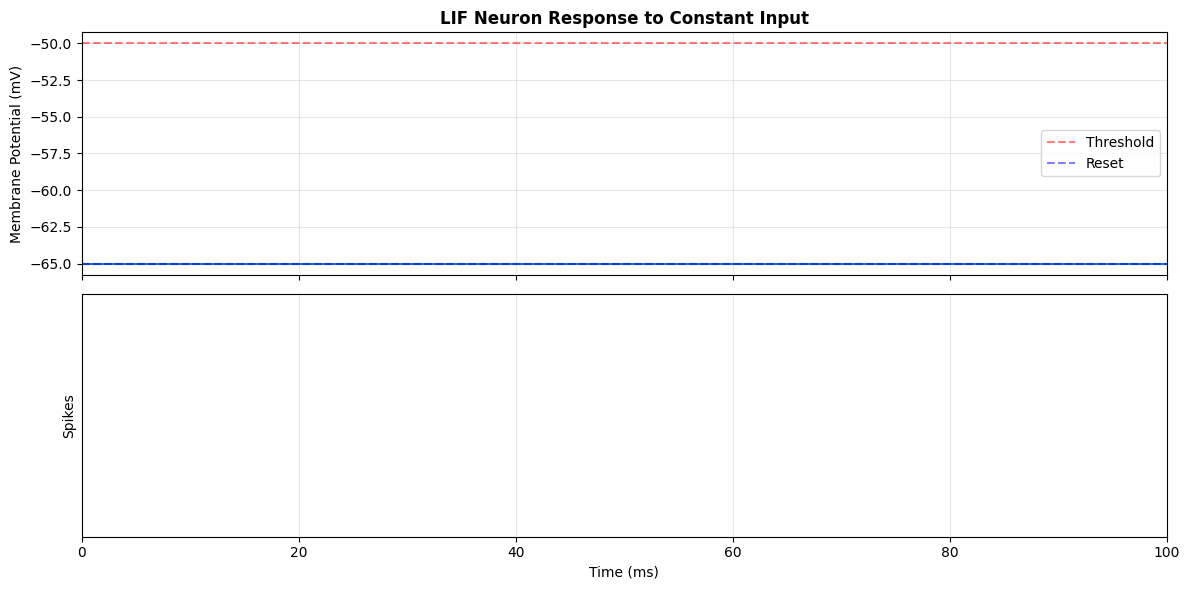


Number of spikes: 0.0
Firing rate: 0.00 * becquerel2


In [3]:
# Reset neuron
brainstate.nn.init_all_states(neuron)

# Simulation parameters
duration = 100. * u.ms
times = u.math.arange(0. * u.ms, duration, brainstate.environ.get_dt())

# Constant input current
I_input = 2.0 * u.nA

# Run simulation
voltages = []
spikes = []

for t in times:
    with brainstate.environ.context(t=t):
        neuron(I_input)
        voltages.append(neuron.V.value[0])
        spikes.append(neuron.get_spike()[0])

voltages = u.math.asarray(voltages)
spikes = u.math.asarray(spikes)

# Visualization
fig, axes = plt.subplots(2, 1, figsize=(12, 6), sharex=True)

# Membrane potential
axes[0].plot(times.to_decimal(u.ms), voltages.to_decimal(u.mV), linewidth=1.5)
axes[0].axhline(neuron.V_th.to_decimal(u.mV), color='red', linestyle='--', alpha=0.5, label='Threshold')
axes[0].axhline(neuron.V_reset.to_decimal(u.mV), color='blue', linestyle='--', alpha=0.5, label='Reset')
axes[0].set_ylabel('Membrane Potential (mV)')
axes[0].set_title('LIF Neuron Response to Constant Input', fontweight='bold')
axes[0].legend()
axes[0].grid(alpha=0.3)

# Spike raster
spike_times = times[spikes > 0]
if len(spike_times) > 0:
    axes[1].eventplot([spike_times.to_decimal(u.ms)], colors='black', linewidths=2)
axes[1].set_ylabel('Spikes')
axes[1].set_xlabel('Time (ms)')
axes[1].set_xlim([0, duration.to_decimal(u.ms)])
axes[1].set_yticks([])
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.show()

# Compute firing rate
num_spikes = u.math.sum(spikes)
firing_rate = num_spikes / duration * 1000 * u.Hz
print(f"\nNumber of spikes: {num_spikes}")
print(f"Firing rate: {firing_rate:.2f}")
if num_spikes > 1:
    isi = duration / num_spikes
    print(f"Mean interspike interval: {isi:.2f}")

### F-I Curve: Firing Rate vs Input Current

A fundamental characterization of neurons is the F-I (Frequency-Input) curve, showing how firing rate depends on input current.

In [ ]:
# Test different input currents
currents = u.math.linspace(0.5, 5.0, 20) * u.nA
firing_rates = []

duration = 500. * u.ms
times = u.math.arange(0. * u.ms, duration, brainstate.environ.get_dt())

for I in currents:
    brainstate.nn.init_all_states(neuron)
    spikes = []
    
    for t in times:
        with brainstate.environ.context(t=t):
            neuron(I)
            spikes.append(neuron.get_spike()[0])
    
    num_spikes = u.math.sum(u.math.asarray(spikes))
    rate = num_spikes / duration * 1000 * u.Hz
    firing_rates.append(rate)

firing_rates = u.math.asarray(firing_rates)

# Plot F-I curve
plt.figure(figsize=(10, 6))
plt.plot(currents.to_decimal(u.nA), firing_rates.to_decimal(u.Hz), 'o-', linewidth=2, markersize=6)
plt.xlabel('Input Current (nA)', fontsize=12)
plt.ylabel('Firing Rate (Hz)', fontsize=12)
plt.title('F-I Curve: Firing Rate vs Input Current', fontweight='bold', fontsize=14)
plt.grid(alpha=0.3)
plt.show()

print("✅ LIF neurons show approximately linear F-I relationship above threshold")

## 2. Exponential Synapses

Synaptic currents follow exponential dynamics:

$$\tau_{syn} \frac{dg}{dt} = -g$$

When a presynaptic spike occurs, $g$ increases instantaneously. This models the time course of neurotransmitter in the synaptic cleft.

### Exponential Euler Method

BrainState uses the exponential Euler method for linear differential equations, which is **exact** and more stable than standard Euler integration.

In [ ]:
# Create exponential synapse
synapse = brainpy.state.Expon(
    size=1,
    tau=5. * u.ms,
    g_initializer=braintools.init.Constant(0.)
)

brainstate.nn.init_all_states(synapse)

# Simulate with spike train input
duration = 50. * u.ms
times = u.math.arange(0. * u.ms, duration, brainstate.environ.get_dt())
spike_times = [10., 15., 20., 30.] * u.ms

conductances = []
for t in times:
    # Check if there's a spike at this time
    spike = u.math.any(u.math.abs(t - spike_times) < brainstate.environ.get_dt() / 2)
    spike_input = u.math.asarray([1.0]) if spike else u.math.asarray([0.0])
    
    with brainstate.environ.context(t=t):
        synapse(spike_input)
        conductances.append(synapse.g.value[0])

conductances = u.math.asarray(conductances)

# Plot
plt.figure(figsize=(12, 6))
plt.plot(times.to_decimal(u.ms), conductances, linewidth=2, label='Synaptic conductance')

# Mark spike times
for st in spike_times:
    plt.axvline(st.to_decimal(u.ms), color='red', linestyle='--', alpha=0.5)

plt.xlabel('Time (ms)', fontsize=12)
plt.ylabel('Conductance (a.u.)', fontsize=12)
plt.title(f'Exponential Synapse Dynamics (τ = {synapse.tau})', fontweight='bold', fontsize=14)
plt.legend()
plt.grid(alpha=0.3)
plt.show()

print(f"Synaptic time constant: {synapse.tau}")
print("✅ Exponential Euler integration is exact for this linear ODE")

## 3. Two-Neuron Network with Synaptic Connection

Now let's connect two neurons with an exponential synapse to see how spikes propagate through a network.

In [ ]:
class TwoNeuronNet(brainstate.nn.Module):
    def __init__(self):
        super().__init__()
        
        # Two LIF neurons
        self.pre = brainpy.state.LIF(
            1, V_rest=-65. * u.mV, V_th=-50. * u.mV, 
            V_reset=-65. * u.mV, tau=10. * u.ms
        )
        self.post = brainpy.state.LIF(
            1, V_rest=-65. * u.mV, V_th=-50. * u.mV,
            V_reset=-65. * u.mV, tau=20. * u.ms  # Slower dynamics
        )
        
        # Synaptic projection from pre to post
        self.syn = brainpy.state.AlignPostProj(
            comm=brainstate.nn.EventFixedProb(1, 1, prob=1.0, weight=50. * u.mS),
            syn=brainpy.state.Expon.desc(1, tau=5. * u.ms),
            out=brainpy.state.CUBA.desc(scale=u.volt),  # Current-based
            post=self.post
        )
    
    def update(self, t, I_pre):
        with brainstate.environ.context(t=t):
            # Update presynaptic neuron
            self.pre(I_pre)
            
            # Propagate spikes through synapse
            self.syn(self.pre.get_spike())
            
            # Update postsynaptic neuron (gets input from synapse)
            self.post(0. * u.nA)
            
            return self.pre.V.value, self.post.V.value, self.pre.get_spike(), self.post.get_spike()


# Create network
net = TwoNeuronNet()
brainstate.nn.init_all_states(net)

# Simulate with input only to presynaptic neuron
duration = 150. * u.ms
times = u.math.arange(0. * u.ms, duration, brainstate.environ.get_dt())
I_pre = 2.5 * u.nA  # Strong input to pre neuron

V_pre_history = []
V_post_history = []
spikes_pre = []
spikes_post = []

for t in times:
    V_pre, V_post, spk_pre, spk_post = net.update(t, I_pre)
    V_pre_history.append(V_pre[0])
    V_post_history.append(V_post[0])
    spikes_pre.append(spk_pre[0])
    spikes_post.append(spk_post[0])

V_pre_history = u.math.asarray(V_pre_history)
V_post_history = u.math.asarray(V_post_history)
spikes_pre = u.math.asarray(spikes_pre)
spikes_post = u.math.asarray(spikes_post)

# Visualization
fig, axes = plt.subplots(3, 1, figsize=(14, 9), sharex=True)

# Presynaptic neuron
axes[0].plot(times.to_decimal(u.ms), V_pre_history.to_decimal(u.mV), linewidth=1.5, label='Pre neuron', color='blue')
axes[0].axhline(-50, color='red', linestyle='--', alpha=0.3)
axes[0].set_ylabel('V_pre (mV)', fontsize=11)
axes[0].set_title('Two-Neuron Network: Synaptic Transmission', fontweight='bold', fontsize=14)
axes[0].legend()
axes[0].grid(alpha=0.3)

# Postsynaptic neuron
axes[1].plot(times.to_decimal(u.ms), V_post_history.to_decimal(u.mV), linewidth=1.5, label='Post neuron', color='green')
axes[1].axhline(-50, color='red', linestyle='--', alpha=0.3)
axes[1].set_ylabel('V_post (mV)', fontsize=11)
axes[1].legend()
axes[1].grid(alpha=0.3)

# Spike rasters
spike_times_pre = times[spikes_pre > 0].to_decimal(u.ms)
spike_times_post = times[spikes_post > 0].to_decimal(u.ms)

if len(spike_times_pre) > 0:
    axes[2].eventplot([spike_times_pre], lineoffsets=[0], colors='blue', linewidths=2, label='Pre')
if len(spike_times_post) > 0:
    axes[2].eventplot([spike_times_post], lineoffsets=[1], colors='green', linewidths=2, label='Post')

axes[2].set_ylabel('Neuron', fontsize=11)
axes[2].set_xlabel('Time (ms)', fontsize=12)
axes[2].set_yticks([0, 1])
axes[2].set_yticklabels(['Pre', 'Post'])
axes[2].set_xlim([0, duration.to_decimal(u.ms)])
axes[2].grid(alpha=0.3)

plt.tight_layout()
plt.show()

print(f"Presynaptic spikes: {u.math.sum(spikes_pre)}")
print(f"Postsynaptic spikes: {u.math.sum(spikes_post)}")
print("\n✅ Spikes from pre neuron cause EPSPs in post neuron")
print("✅ Post neuron fires when EPSPs sum to threshold")

## 4. E/I Balanced Network

A fundamental architecture in neuroscience is the Excitatory-Inhibitory (E/I) balanced network. These networks exhibit rich dynamics and are found throughout the cortex.

We'll implement a simplified version inspired by:
- Van Vreeswijk & Sompolinsky (1996)
- Brunel (2000)

### Network Architecture

- **80% excitatory** neurons (E)
- **20% inhibitory** neurons (I)  
- Sparse random connectivity
- Balance between excitation and inhibition

In [ ]:
class EINet(brainstate.nn.Module):
    """Excitatory-Inhibitory balanced network."""
    
    def __init__(self, n_exc=400, n_inh=100, prob=0.1):
        super().__init__()
        self.n_exc = n_exc
        self.n_inh = n_inh
        self.num = n_exc + n_inh
        
        # Network of LIF neurons
        self.N = brainpy.state.LIF(
            self.num,
            V_rest=-60. * u.mV,
            V_th=-50. * u.mV,
            V_reset=-60. * u.mV,
            tau=20. * u.ms,
            V_initializer=braintools.init.Normal(-55. * u.mV, 5. * u.mV)
        )
        
        # Excitatory synaptic projection
        JE = 0.5 / u.math.sqrt(prob * n_exc) * u.mS
        self.E = brainpy.state.AlignPostProj(
            comm=brainstate.nn.EventFixedProb(n_exc, self.num, prob=prob, weight=JE),
            syn=brainpy.state.Expon.desc(self.num, tau=5. * u.ms),
            out=brainpy.state.CUBA.desc(scale=u.volt),
            post=self.N
        )
        
        # Inhibitory synaptic projection (stronger)
        JI = -4.0 / u.math.sqrt(prob * n_inh) * u.mS
        self.I = brainpy.state.AlignPostProj(
            comm=brainstate.nn.EventFixedProb(n_inh, self.num, prob=prob, weight=JI),
            syn=brainpy.state.Expon.desc(self.num, tau=10. * u.ms),
            out=brainpy.state.CUBA.desc(scale=u.volt),
            post=self.N
        )
    
    def update(self, t, I_ext):
        with brainstate.environ.context(t=t):
            # Get spikes from neurons
            spikes = self.N.get_spike() != 0.
            
            # Propagate E and I spikes
            self.E(spikes[:self.n_exc])
            self.I(spikes[self.n_exc:])
            
            # Update neurons
            self.N(I_ext)
            
            return self.N.get_spike()


# Create network
print("Building E/I balanced network...")
net = EINet(n_exc=400, n_inh=100, prob=0.1)
brainstate.nn.init_all_states(net)

print(f"Network size: {net.num} neurons")
print(f"  Excitatory: {net.n_exc} (80%)")
print(f"  Inhibitory: {net.n_inh} (20%)")
print(f"\nApproximate connections per neuron: {0.1 * net.num:.0f}")

### Simulating the E/I Network

In [ ]:
# Simulation parameters
duration = 500. * u.ms
times = u.math.arange(0. * u.ms, duration, brainstate.environ.get_dt())

# External input to all neurons
I_ext = u.math.ones(net.num) * 0.5 * u.nA

print("Running simulation...")
# Run simulation using for_loop with progress bar
spikes = brainstate.transform.for_loop(
    lambda t: net.update(t, I_ext),
    times,
    pbar=brainstate.transform.ProgressBar(count=10)
)

print("Simulation complete!")

### Analyzing Network Activity

In [ ]:
# Extract spike times and neuron indices
t_indices, n_indices = u.math.where(spikes)
spike_times = times[t_indices]

# Separate E and I populations
e_mask = n_indices < net.n_exc
i_mask = n_indices >= net.n_exc

# Create visualizations
fig, axes = plt.subplots(3, 1, figsize=(14, 10))

# 1. Raster plot
axes[0].scatter(
    spike_times[e_mask].to_decimal(u.ms), n_indices[e_mask],
    s=1, c='blue', alpha=0.5, label='Excitatory'
)
axes[0].scatter(
    spike_times[i_mask].to_decimal(u.ms), n_indices[i_mask],
    s=1, c='red', alpha=0.5, label='Inhibitory'
)
axes[0].axhline(net.n_exc, color='gray', linestyle='--', alpha=0.5, linewidth=1)
axes[0].set_ylabel('Neuron Index', fontsize=11)
axes[0].set_title('E/I Balanced Network Activity', fontweight='bold', fontsize=14)
axes[0].legend(loc='upper right')
axes[0].grid(alpha=0.3)
axes[0].set_xlim([0, duration.to_decimal(u.ms)])

# 2. Population firing rates
window = 50  # ms
window_steps = int(window / brainstate.environ.get_dt().to_decimal(u.ms))

# Excitatory population rate
e_activity = u.math.sum(spikes[:, :net.n_exc], axis=1)
e_rate = jnp.convolve(e_activity, jnp.ones(window_steps) / window_steps, mode='same')
e_rate = e_rate / net.n_exc * 1000  # Hz

# Inhibitory population rate
i_activity = u.math.sum(spikes[:, net.n_exc:], axis=1)
i_rate = jnp.convolve(i_activity, jnp.ones(window_steps) / window_steps, mode='same')
i_rate = i_rate / net.n_inh * 1000  # Hz

axes[1].plot(times.to_decimal(u.ms), e_rate, linewidth=2, color='blue', label='Excitatory', alpha=0.8)
axes[1].plot(times.to_decimal(u.ms), i_rate, linewidth=2, color='red', label='Inhibitory', alpha=0.8)
axes[1].set_ylabel('Firing Rate (Hz)', fontsize=11)
axes[1].legend()
axes[1].grid(alpha=0.3)

# 3. Total population activity
total_activity = u.math.sum(spikes, axis=1)
total_rate = jnp.convolve(total_activity, jnp.ones(window_steps) / window_steps, mode='same')
total_rate = total_rate / net.num * 1000  # Hz

axes[2].plot(times.to_decimal(u.ms), total_rate, linewidth=2, color='black', alpha=0.8)
axes[2].fill_between(times.to_decimal(u.ms), 0, total_rate, alpha=0.3, color='gray')
axes[2].set_ylabel('Population Rate (Hz)', fontsize=11)
axes[2].set_xlabel('Time (ms)', fontsize=12)
axes[2].grid(alpha=0.3)

plt.tight_layout()
plt.show()

# Statistics
total_spikes = u.math.sum(spikes)
mean_rate = total_spikes / (duration.to_decimal(u.ms) * net.num / 1000)
e_spikes = u.math.sum(spikes[:, :net.n_exc])
i_spikes = u.math.sum(spikes[:, net.n_exc:])

print("\n" + "="*50)
print("Network Statistics")
print("="*50)
print(f"Total spikes: {total_spikes}")
print(f"Mean firing rate: {mean_rate:.2f} Hz")
print(f"\nExcitatory population:")
print(f"  Spikes: {e_spikes}")
print(f"  Mean rate: {e_spikes / (duration.to_decimal(u.ms) * net.n_exc / 1000):.2f} Hz")
print(f"\nInhibitory population:")
print(f"  Spikes: {i_spikes}")
print(f"  Mean rate: {i_spikes / (duration.to_decimal(u.ms) * net.n_inh / 1000):.2f} Hz")
print("\n✅ Network shows asynchronous irregular activity")
print("✅ E and I populations are dynamically balanced")

## Summary

In this tutorial, you learned how to build realistic spiking neural networks using the BrainPy ecosystem:

### Key Concepts

✅ **LIF Neurons**
  - Standard model in computational neuroscience
  - Simple but captures essential spiking dynamics
  - F-I curves characterize neuronal excitability

✅ **Exponential Euler Integration**
  - Exact for linear ODEs
  - More stable than standard Euler
  - Used automatically by BrainPy for efficiency

✅ **Synaptic Dynamics**
  - Exponential synapses model neurotransmitter kinetics
  - Time constants determine temporal filtering
  - CUBA: Current-Based synapses

✅ **Network Architectures**
  - E/I balance is crucial for cortical function
  - Sparse connectivity enables large-scale simulations
  - Asynchronous irregular activity emerges naturally

### Best Practices

1. 🎯 **Use Physical Units** - BrainUnit prevents unit errors
2. ⚡ **Leverage BrainPy Models** - Pre-built, validated neuron/synapse models
3. 📊 **Analyze Population Dynamics** - Raster plots, firing rates, synchrony
4. 🔧 **Initialize States** - Always call `init_all_states()` before simulation
5. 🚀 **Use JIT Compilation** - `for_loop` with JIT for fast simulations

### BrainPy Ecosystem Components

| Component | Purpose |
|-----------|----------|
| **brainstate** | State management, transformations |
| **brainpy** | Neuron models, synapses, networks |
| **brainunit** | Physical units (mV, ms, nA, etc.) |
| **braintools** | Utilities, initializers, optimizers |

### Applications

- 🧠 **Computational Neuroscience** - Model biological neural circuits
- 🤖 **Neuromorphic Computing** - Event-driven, energy-efficient computing
- 🎓 **Machine Learning** - Spiking neural networks for temporal processing
- 🔬 **Research** - Test hypotheses about brain function

### Next Steps

Explore more advanced topics:
- **Training SNNs** - Surrogate gradient methods
- **Complex Neuron Models** - Hodgkin-Huxley, AdEx, Izhikevich
- **Network Phenomena** - Gamma oscillations, working memory, decision-making
- **Synaptic Plasticity** - STDP, short-term plasticity

### Additional Resources

- 📚 [BrainPy Documentation](https://brainpy.readthedocs.io/)
- 📖 [Neuronal Dynamics (Gerstner et al.)](https://neuronaldynamics.epfl.ch/)
- 🔬 [Computational Neuroscience Course](https://www.coursera.org/learn/computational-neuroscience)
- 💻 [BrainPy Examples](https://brainpy-state.readthedocs.io/)